In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor,XGBClassifier
from utils import LogScaler

from pandas.core.common import SettingWithCopyWarning
import warnings

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
df = pd.read_csv('kaggle/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
df.drop('Id',axis=1,inplace=True)

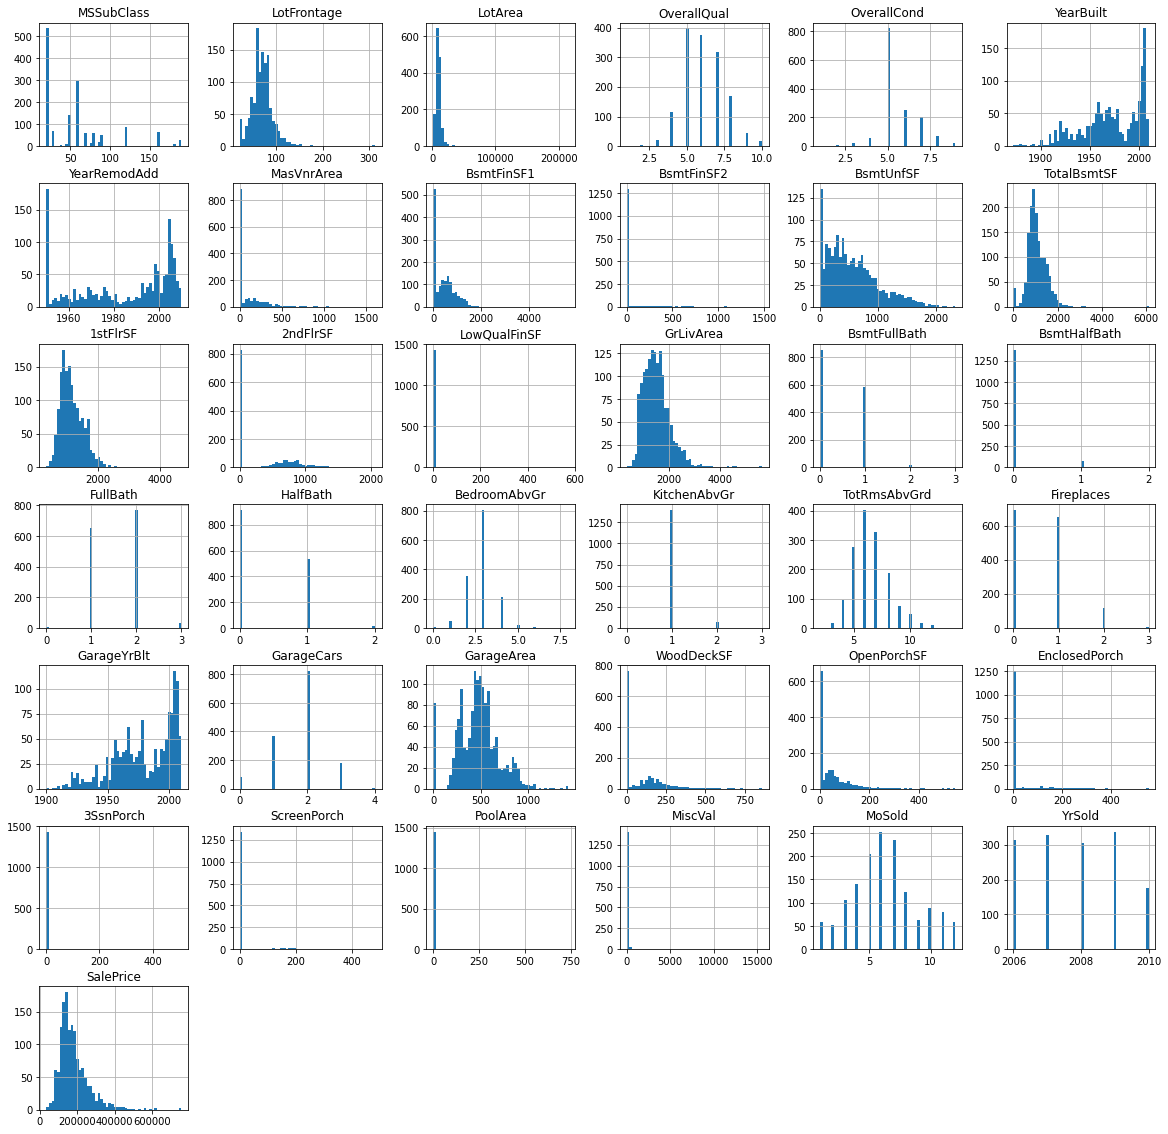

In [4]:
# check distribution
df.hist(bins=50,figsize=(20,20))
plt.show()

The data is somewhat skewwed to the left, mostly. Now, visualising with log transformation

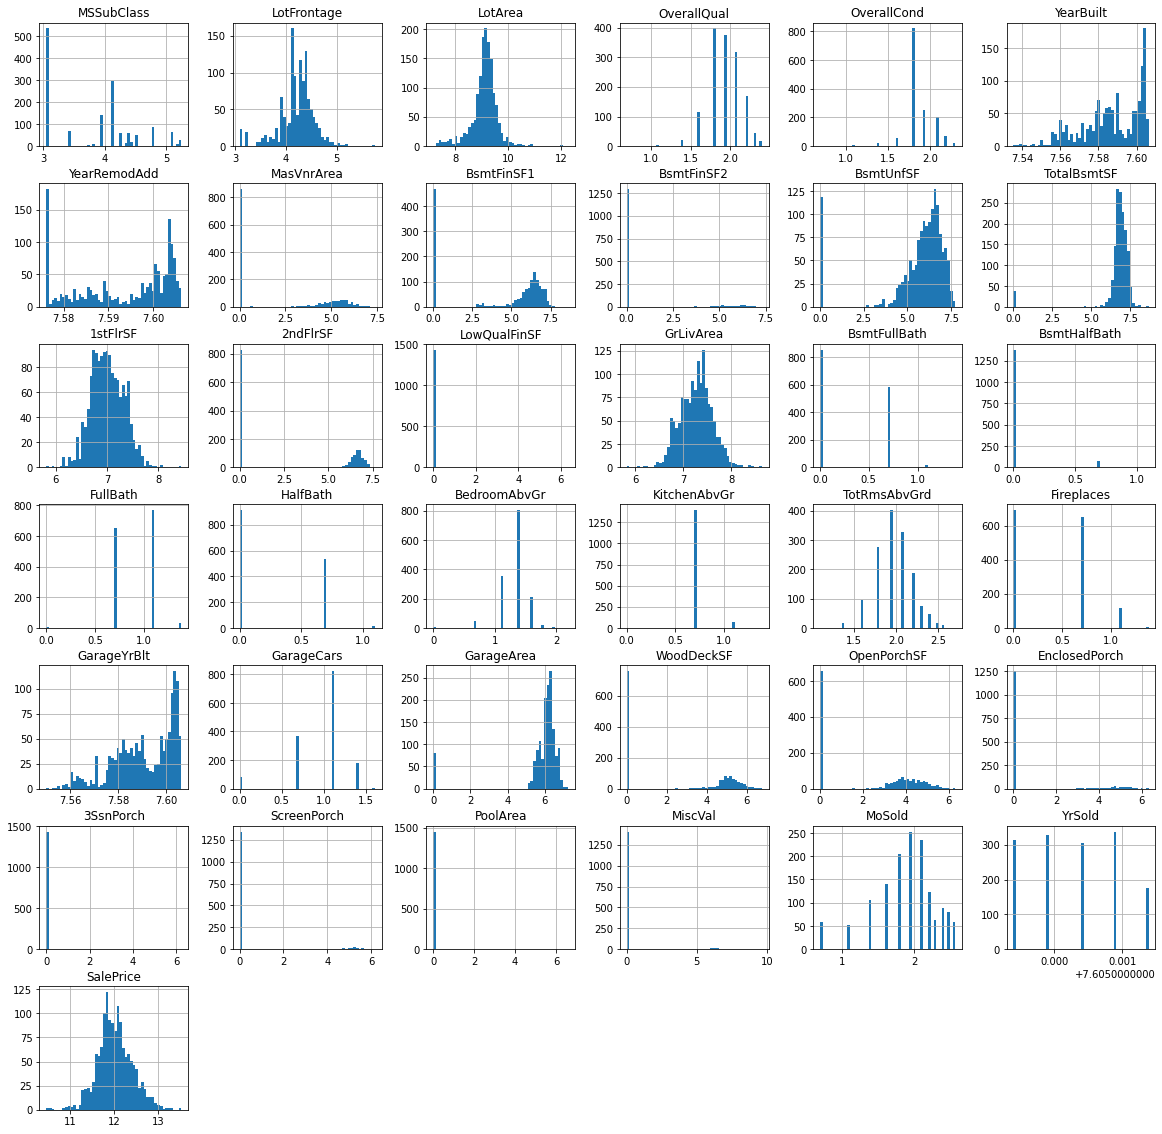

In [5]:
columns = [x for x in df.columns if df[x].dtype!='O']
df_log = pd.DataFrame(np.log(df[columns]+1),columns=columns)
df_log
df_log.hist(bins=50,figsize=(20,20))
plt.show()

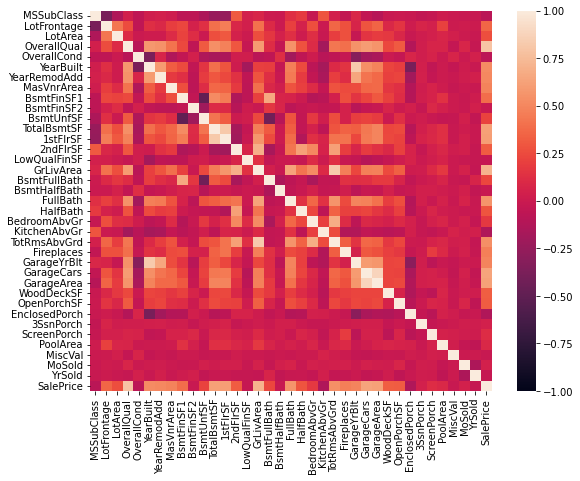

In [6]:
# check correlations
plt.figure(figsize=(9,7))
sb.heatmap(df.corr(),vmax=1,vmin=-1)
plt.show()

OverallQual and GrLivArea have the highest correlation with SalePrice

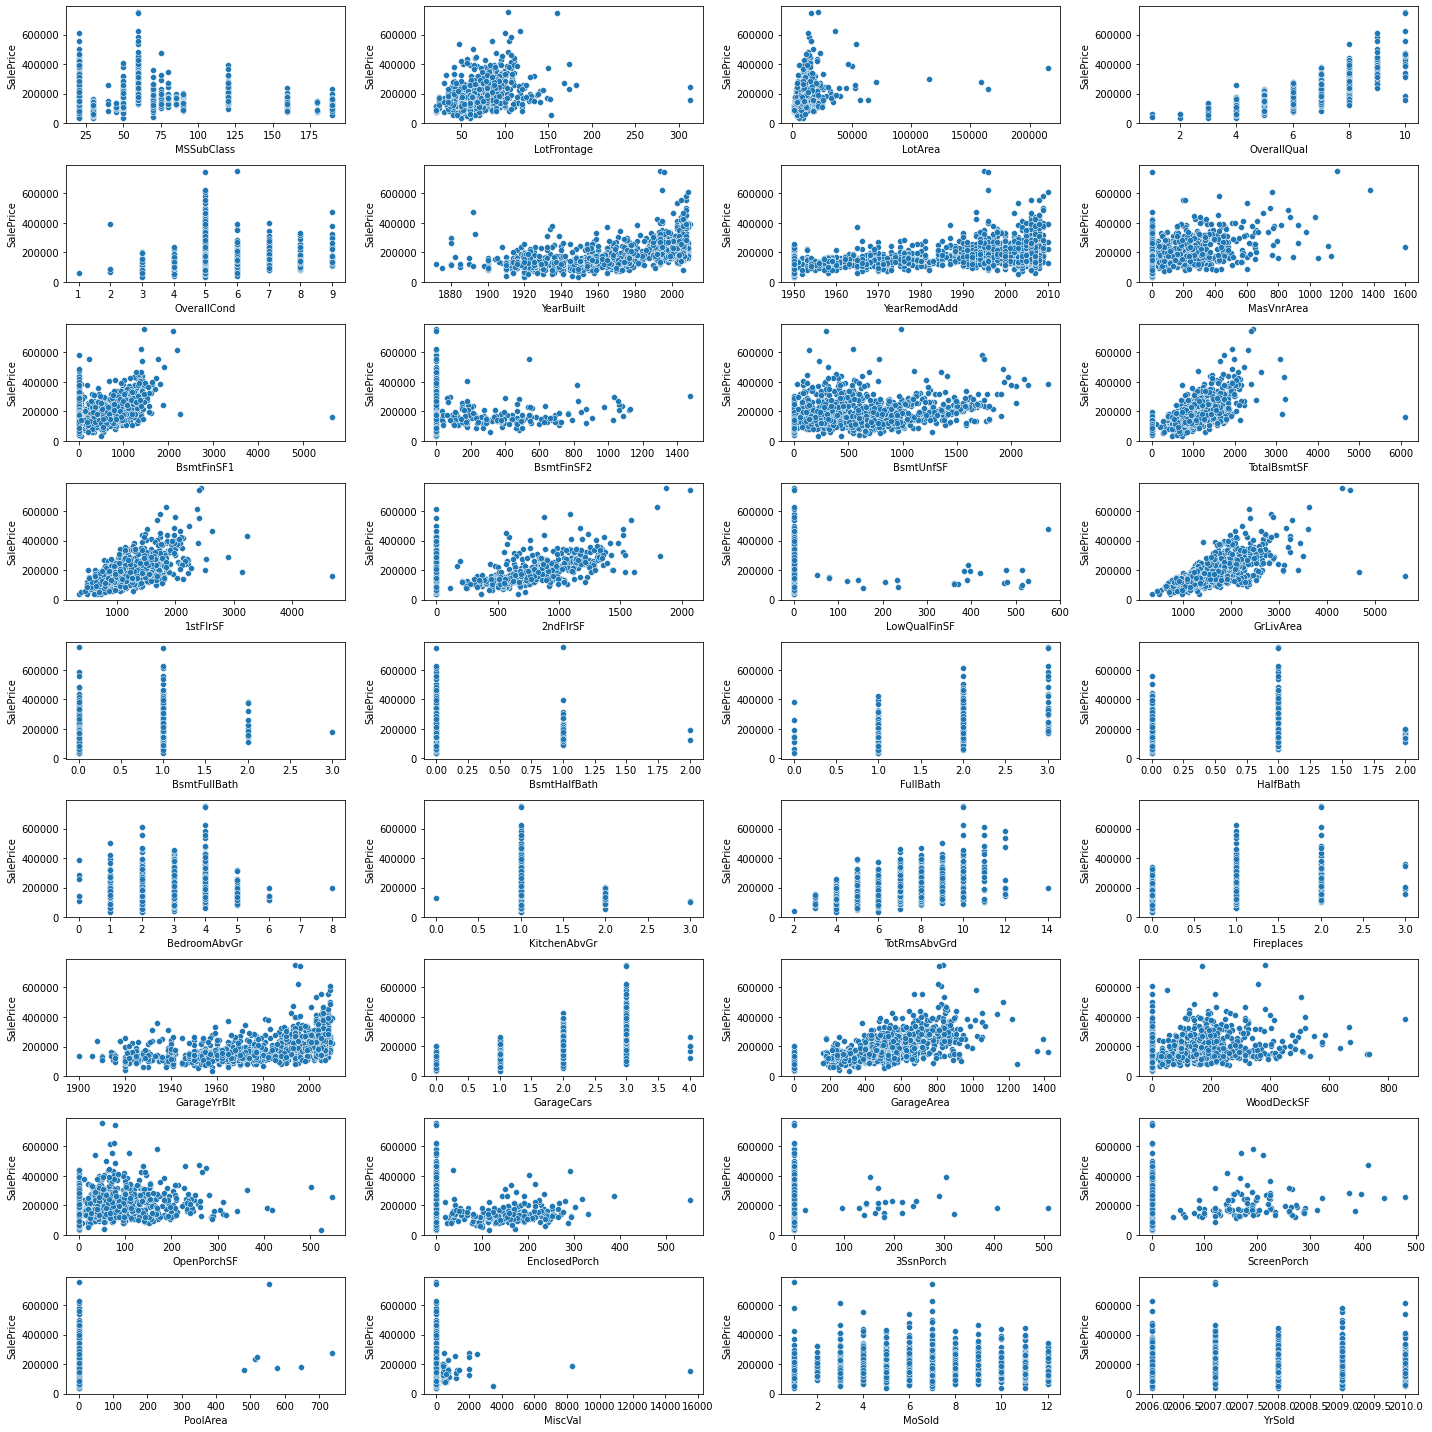

In [7]:
# visulising relationship with target feature
columns = [x for x in df.columns if df[x].dtype!='O']
columns.remove('SalePrice')
columns = np.array(columns).reshape((9,4))

fig,axes = plt.subplots(ncols=4,nrows=9,figsize=(20,20))
for i in range(9):
    for j in range(4):
        sb.scatterplot(x=df[columns[i,j]],y=df.SalePrice,ax=(axes[i,j]))
        
plt.tight_layout()


1. Newly built houses with larger area are more expensive
2. The type of porch doesn't seem to have much effect on the SalePrice

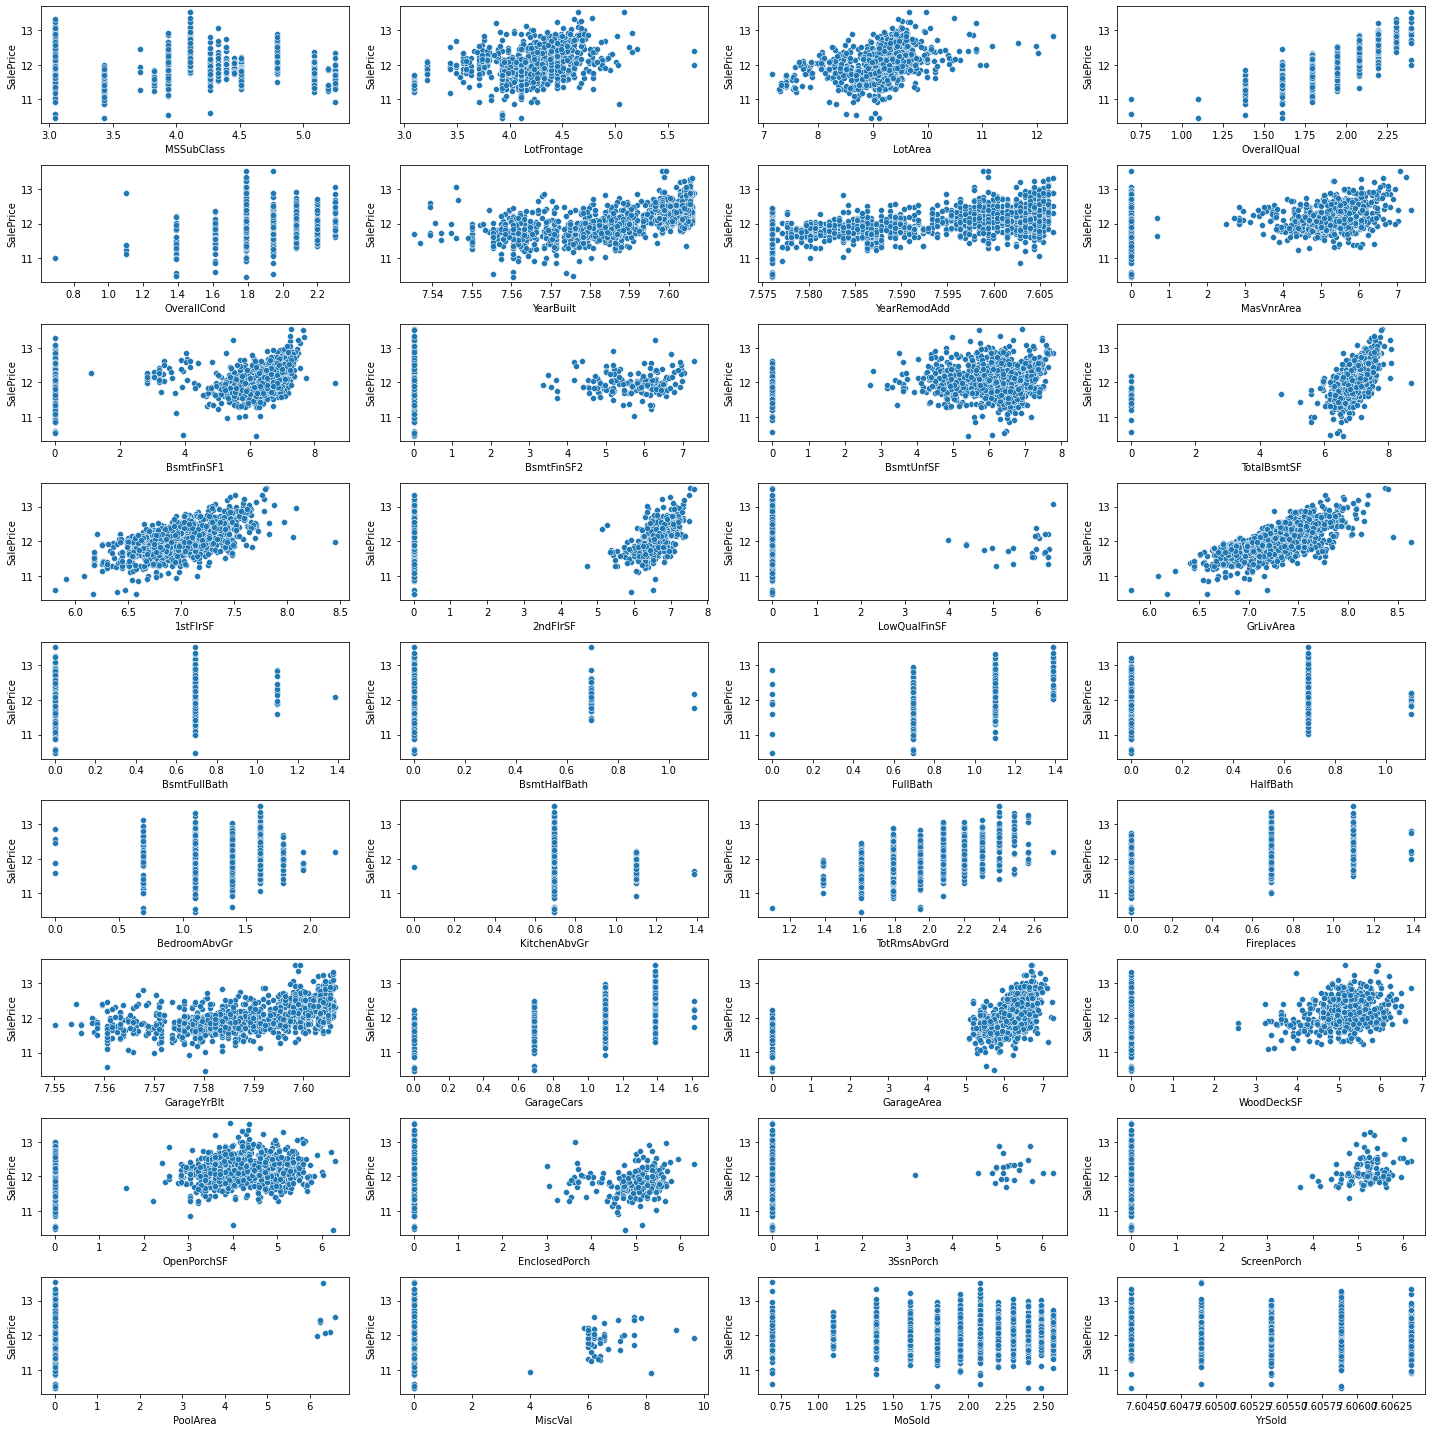

In [8]:
# applying log transformation and visualising the relationship again
columns = [x for x in df.columns if df[x].dtype!='O']
columns.remove('SalePrice')
columns = np.array(columns).reshape((9,4))

fig,axes = plt.subplots(ncols=4,nrows=9,figsize=(20,20))
for i in range(9):
    for j in range(4):
        sb.scatterplot(x=df_log[columns[i,j]],y=df_log.SalePrice,ax=(axes[i,j]))
        
plt.tight_layout()

In [9]:
# get columns with missing values

missing = []

for col in df.columns:
    if df[col].isnull().mean()>0:
        missing.append((col,df[col].isnull().mean()))
        
missing = sorted(missing,key=lambda x: x[1],reverse=True)

for col in missing:
    print(col[0],col[1])

PoolQC 0.9952054794520548
MiscFeature 0.963013698630137
Alley 0.9376712328767123
Fence 0.8075342465753425
FireplaceQu 0.4726027397260274
LotFrontage 0.1773972602739726
GarageType 0.05547945205479452
GarageYrBlt 0.05547945205479452
GarageFinish 0.05547945205479452
GarageQual 0.05547945205479452
GarageCond 0.05547945205479452
BsmtExposure 0.026027397260273973
BsmtFinType2 0.026027397260273973
BsmtQual 0.025342465753424658
BsmtCond 0.025342465753424658
BsmtFinType1 0.025342465753424658
MasVnrType 0.005479452054794521
MasVnrArea 0.005479452054794521
Electrical 0.0006849315068493151


The top 4 columns have more than 80% of missing data. As per the description, the missing values refer to NA (Not Avalaible)

In [10]:
col = ['PoolQC','MiscFeature','Alley','Fence']

for c in col:
    df[c].fillna('NA',inplace=True)

In [11]:
# again, get columns with missing values
for col in df.columns:
    if df[col].isnull().mean()>0:
        print(col,df[col].isnull().mean(),df[col].dtype)

LotFrontage 0.1773972602739726 float64
MasVnrType 0.005479452054794521 object
MasVnrArea 0.005479452054794521 float64
BsmtQual 0.025342465753424658 object
BsmtCond 0.025342465753424658 object
BsmtExposure 0.026027397260273973 object
BsmtFinType1 0.025342465753424658 object
BsmtFinType2 0.026027397260273973 object
Electrical 0.0006849315068493151 object
FireplaceQu 0.4726027397260274 object
GarageType 0.05547945205479452 object
GarageYrBlt 0.05547945205479452 float64
GarageFinish 0.05547945205479452 object
GarageQual 0.05547945205479452 object
GarageCond 0.05547945205479452 object


There columns with less than 5% of missing data. So, the continous features can be filled with the median and the categorical ones with the mode

In [12]:
# imputing the missing values
for col in df.columns:
    if 0<df[col].isnull().mean()<=0.05:
        if df[col].dtype == 'O':
            df[col].fillna(df[col].mode()[0],inplace=True)
        else:
            df[col].fillna(df[col].median(),inplace=True)

# one hot encode the categorical features    
cols = [x for x in df.select_dtypes('O').columns if df[x].isnull().sum()==0]
dummies = pd.get_dummies(df[cols],drop_first=True)
df = pd.concat([df,dummies],axis=1)
df.drop(cols,axis=1,inplace=True)

In [13]:
# gather the remaining columns with missing values
to_drop = []
for c in df.columns:
    if df[c].isnull().mean()>0:
        print(c,df[c].isnull().mean(),df[c].dtype)
        to_drop.append(c)
        
to_drop = to_drop + ['SalePrice']

LotFrontage 0.1773972602739726 float64
FireplaceQu 0.4726027397260274 object
GarageType 0.05547945205479452 object
GarageYrBlt 0.05547945205479452 float64
GarageFinish 0.05547945205479452 object
GarageQual 0.05547945205479452 object
GarageCond 0.05547945205479452 object


In [14]:
# regressor and classifiers for imputing the remaining columns with missing values

def regressor(df,col,target):
    print(target)
    fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,4))
    sb.histplot(x=df[target],bins=50,ax=ax1).set(title="Before Imputation")
    col = [x for x in col if x!=target]
    pred = df.drop(col,axis=1).dropna()
    x = pred.drop(target,axis=1).values
    y = pred[target].values
    reg = XGBRegressor()
    reg.fit(x,y)
    df[target].fillna(0.0,inplace=True)
    index = df[df[target]==0].index
    for i in index:
        x = df.drop(col+[target],axis=1).loc[i].values
        df[target].loc[i] = reg.predict([x])
    sb.histplot(x=df[target],bins=50,ax=ax2).set(title="After Imputation")
    plt.show()
    print()
    
def classifier(df,col,target):
    print(target)
    fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,4))
    pie = df[target].value_counts().to_frame()
    ax1.pie(pie[target],labels=pie.index)
    ax1.set_title('Before Imputation')
    col = [x for x in col if x!=target]
    pred = df.drop(col,axis=1).dropna()
    x = pred.drop(target,axis=1).values
    y = pred[target].values
    reg = RandomForestClassifier()
    reg.fit(x,y)
    df[target].fillna('nan',inplace=True)
    index = df[df[target]=='nan'].index
    for i in index:
        x = df.drop(col+[target],axis=1).loc[i].values
        df[target].loc[i] = reg.predict([x])[0]
    pie = df[target].value_counts().to_frame()
    ax2.pie(pie[target],labels=pie.index)
    ax2.set_title('After Imputation')
    plt.show()
    print()
    
    

In [ ]:
# impute the missing values in the remaining features
classifier(df,to_drop,'FireplaceQu')
regressor(df,to_drop,'GarageYrBlt')
regressor(df,to_drop,'LotFrontage')
classifier(df,to_drop,'GarageType')
classifier(df,to_drop,'GarageFinish')
classifier(df,to_drop,'GarageCond')
classifier(df,to_drop,'GarageQual')

FireplaceQu


The distribution of values in all the columns before and after imputation are almost similar except for FireplaceQu because it had almost 50% missing values

In [ ]:
to_drop.remove('SalePrice')

In [ ]:
# one hot encode the remaining categorical features
cols = [x for x in to_drop if df[x].dtype == 'O']
dummies = pd.get_dummies(df[cols],drop_first=True)
df = pd.concat([df,dummies],axis=1)
df.drop(cols,axis=1,inplace=True)

In [ ]:
# final check for missing values
for c in df.columns:
    if df[c].isnull().sum():print(c)
else:
    print('all filled')

In [ ]:
df.SalePrice.hist(bins=50)

As per distribution, its better to limit the data to SalePrice=500000

In [ ]:
train = df[df.SalePrice<=500000]
len(train)/len(df)

In [ ]:
# selecting features that have correlation more than 0.1 or less than -0.1 with the target feature
cor = dict(df.corrwith(df.SalePrice).sort_values())
keep_cols = [x for x in cor if cor[x]>0.1 or cor[x]<-0.1]
if 'SalePrice' not in cols: cols.append('SalePrice')

In [ ]:
# splitting and scaling the data
x = train[keep_cols].drop('SalePrice',axis=1).values
y = train.SalePrice.values
xtrain,xtest,ytrain,ytest = train_test_split(x,y,train_size=0.7,random_state=0)
scaler = LogScaler()
xtrain,ytrain = scaler.fit_transform(xtrain,ytrain)
xtest = scaler.transform(xtest)

In [ ]:
# applying linear regression and calculating the MSE, RMSE and R2 score on both training and testing data
reg = LinearRegression()
reg.fit(xtrain,ytrain)
pred_train = reg.predict(xtrain)
pred = reg.predict(xtest)

pred_train = np.exp(pred_train)
pred = np.exp(pred)
ytrain = np.exp(ytrain)

print(f'train data\nMSE = {mean_absolute_error(pred_train,ytrain)}\nRMSE = {(mean_squared_error(pred_train,ytrain))**0.5}\nR2 = {r2_score(pred_train,ytrain)}\n')

print(f'test data\nMSE = {mean_absolute_error(pred,ytest)}\nRMSE = {(mean_squared_error(pred,ytest))**0.5}\nR2 = {r2_score(pred,ytest)}')
sb.jointplot(x=ytest,y=pred,kind='reg')

In [ ]:
x,y = df[keep_cols].drop('SalePrice',axis=1).values,df.SalePrice.values
x = scaler.transform(x)
pred = reg.predict(x)
pred = np.exp(pred)
print(f'complete data\nMSE = {mean_absolute_error(pred,y)}\nRMSE = {(mean_squared_error(pred,y))**0.5}\nR2 = {r2_score(pred,y)}')
sb.jointplot(x=y,y=pred,kind='reg')